In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import assessment 
import calibration 
import pandas as pd
%matplotlib inline
import our_calibration

### Set plotting aesthetics

In [2]:
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({"axes.grid" : True, "grid.linestyle": '--', 
                     "grid.alpha": 0.8, "grid.color": "black"})
mpl.rcParams.update({"lines.linewidth" : 3})

# Load predictions from pretrained ResNet-50 model on CIFAR10

### Training data is not re-used; only validation data (called calibration data here), and test data is used

In [3]:
logits_calib, logits_test, y_calib, y_test = \
np.loadtxt('data/cifar10_resnet50/val_logits'), np.loadtxt('data/cifar10_resnet50/test_logits'), \
np.loadtxt('data/cifar10_resnet50/val_labels'), np.loadtxt('data/cifar10_resnet50/test_labels')

y_calib = y_calib.astype('int')+1
y_test = y_test.astype('int')+1
preds_calib = np.exp(logits_calib)/np.tile((np.reshape(np.sum(np.exp(logits_calib), axis=1), 
                                                  (logits_calib.shape[0],1))), (1,logits_calib.shape[1]))
preds_test = np.exp(logits_test)/np.tile((np.reshape(np.sum(np.exp(logits_test), axis=1), 
                                                  (logits_test.shape[0],1))), (1,logits_test.shape[1]))

print("Number of calibration points = {:d}".format(preds_calib.shape[0]))
print("Number of test points = {:d}".format(preds_test.shape[0]))

Number of calibration points = 5000
Number of test points = 10000


### For comparison, also load temperature scaling predictions on test data

In [4]:
temp_logits_test = np.loadtxt('data/cifar10_resnet50/test_logits_temp')
temp_preds_test = np.exp(temp_logits_test)/np.tile((np.reshape(np.sum(np.exp(temp_logits_test), axis=1), 
                                                 (temp_logits_test.shape[0],1))), (1,temp_logits_test.shape[1]))

# temperature scaling predictions are shuffled because of which are different from y_test
temp_y_test = np.loadtxt('data/cifar10_resnet50/test_labels_temp').astype('int')+1

# Recalibrate using histogram binning

In [5]:
points_per_bin=50

In [6]:
# initialize recalibrator and set number of points per bins
hb = calibration.HB_toplabel(points_per_bin=points_per_bin)
hb.fit(preds_calib, y_calib)

# get histogram binning probabilities on test data
preds_test_hb = hb.predict_proba(preds_test)

# Calibrate using ours

In [7]:
our_calib = our_calibration.top_label_calibration(points_per_bin=points_per_bin)
our_calib.fit(preds_calib, y_calib)
preds_test_our = our_calib.predict_proba(preds_test)

In [9]:
# top_class_prob = np.max(preds_calib, axis=1)
# top_class_prob_arg = np.argmax(preds_calib, axis=1)+1

# calibrators = {}

# for item in np.unique(top_class_prob_arg):
#     correct_label = np.where(top_class_prob_arg == item)[0]
#     n_l = len(correct_label)
#     bins_l = np.floor(n_l/points_per_bin).astype('int')
#     if(bins_l == 0):
#         print("Predictions for class {:d} not recalibrated since fewer than {:d} calibration points were predicted as class {:d}.".format(item, points_per_bin, item))
#     else:
#         hb_clone = calibration.HB_binary(n_bins=bins_l)
#         y_calib_ = (y_calib[correct_label] == item)
#         top_class_prob_ = top_class_prob[correct_label]
#         hb_clone.fit(top_class_prob_, y_calib_)
#         calibrators[item] = hb_clone


In [10]:
# top_class_prob_TEST = np.max(preds_test, axis=1)
# top_class_prob_arg_TEST = np.argmax(preds_test, axis=1)+1

# n = len(top_class_prob_TEST)
# calibrated_test_values = np.zeros((n))
# for item in np.unique(top_class_prob_arg_TEST):
#     if item in calibrators:
#         correct_label = np.where(top_class_prob_arg_TEST == item)[0]
#         if len(correct_label) > 0:
#             calibrator_ = calibrators[item]
#             preds_ = calibrator_.predict_proba(top_class_prob_TEST[correct_label])
#             calibrated_test_values[correct_label] = preds_


# Assess models using top-label {reliability diagram, ECE}

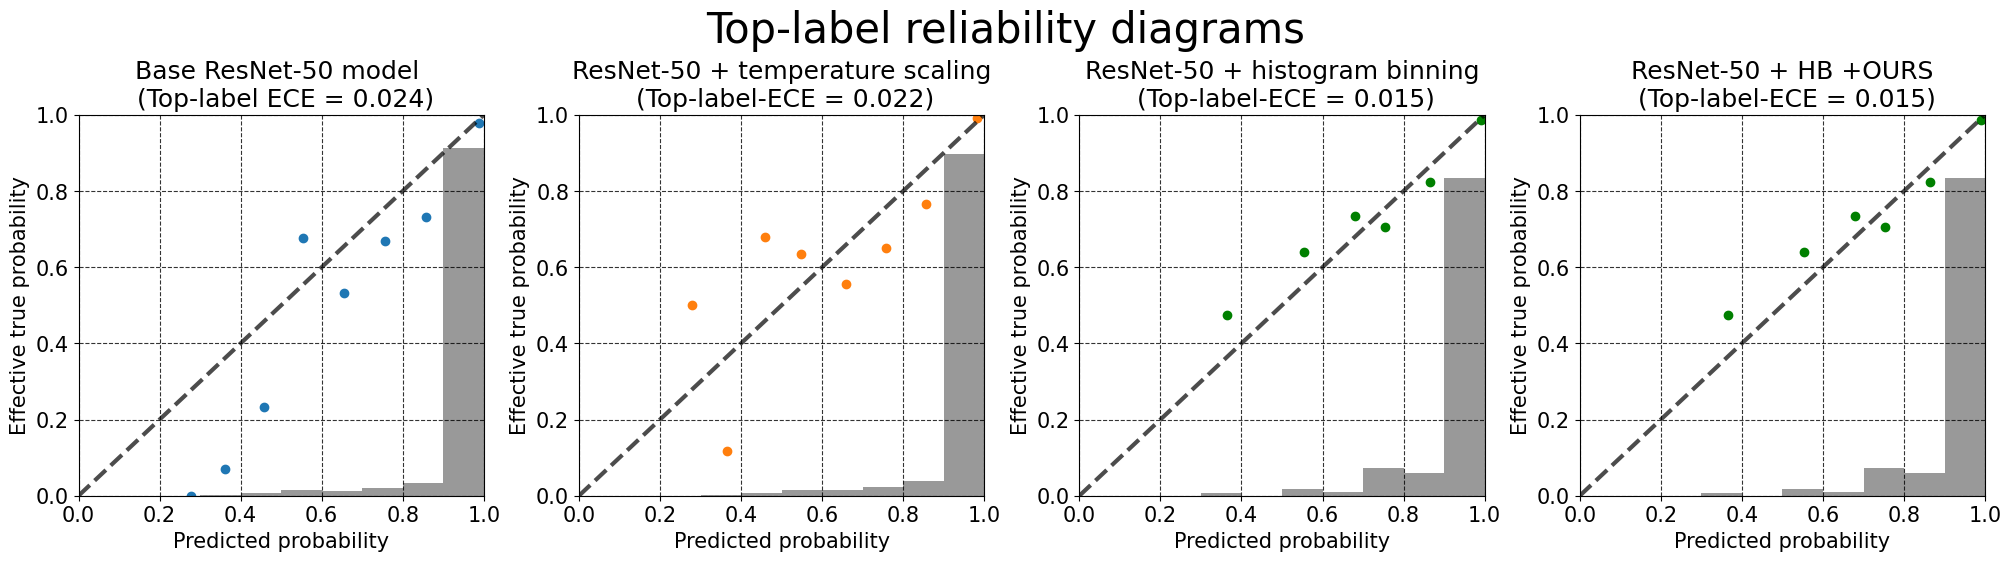

In [11]:
# make some plots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5.5), constrained_layout=True)
fig.suptitle('Top-label reliability diagrams', fontsize=30)

assessment.toplabel_reliability_diagram(y_test, preds_test, ax=ax[0])
ax[0].set_title("Base ResNet-50 model \n (Top-label ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, preds_test)))

assessment.toplabel_reliability_diagram(temp_y_test, temp_preds_test, ax=ax[1], color=(1.0, 0.4980392156862745, 0.054901960784313725))
ax[1].set_title("ResNet-50 + temperature scaling\n (Top-label-ECE = {:.3f})".format(
                                assessment.toplabel_ece(temp_y_test, temp_preds_test)))

assessment.toplabel_reliability_diagram(y_test, preds_test_hb, np.argmax(preds_test, axis=1)+1, ax=ax[2], color='g')
ax[2].set_title("ResNet-50 + histogram binning\n (Top-label-ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, preds_test_hb, np.argmax(preds_test, axis=1)+1)));


assessment.toplabel_reliability_diagram(y_test, preds_test_our, np.argmax(preds_test, axis=1)+1, ax=ax[3], color='g')
ax[3].set_title("ResNet-50 + HB +OURS\n (Top-label-ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, preds_test_our, np.argmax(preds_test, axis=1)+1)));